# Recognize Facial Expressions Using Deep Learning, Resnet152, PyTorch and Transfer Learning


The Facial Expression Recognition can be featured as one of the classification jobs people might like to include in the set of computer vision. The job of our project will be to look through a camera that will be used as eyes for the machine and classify the face of the person (if any) based on his current expression/mood.

##Dataset
I found this dataset on kaggle, and it represents an image classification problem; since the data consists of six classes with each class containing between 3000-7000 images with six classes as 'Happy', 'Suprise', 'Sad', 'Fear', 'Angry', 'Neutral'.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/apollo2506/facial-recognition-dataset'

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./facial-recognition-dataset" (use force=True to force download)


In [ ]:
import os
dataset = './facial-recognition-dataset'
print(os.listdir(dataset))


['Testing', 'Training']


In [ ]:
classes = os.listdir(dataset + "/Training"+ "/Training")
print(classes)

['Happy', 'Suprise', 'Sad', 'Fear', 'Angry', 'Neutral']


In [ ]:
data_dir = dataset

train_dir = data_dir + '/Training' + '/Training'
test_dir = data_dir + '/Testing' + '/Testing'

In [ ]:
count = []
for folder in classes:
    num_images = len(os.listdir(train_dir+'/'+ folder))
    count.append(num_images)
    print(f'There are {num_images} images in the {folder} category.')

There are 7215 images in the Happy category.
There are 3171 images in the Suprise category.
There are 4830 images in the Sad category.
There are 4097 images in the Fear category.
There are 3995 images in the Angry category.
There are 4965 images in the Neutral category.


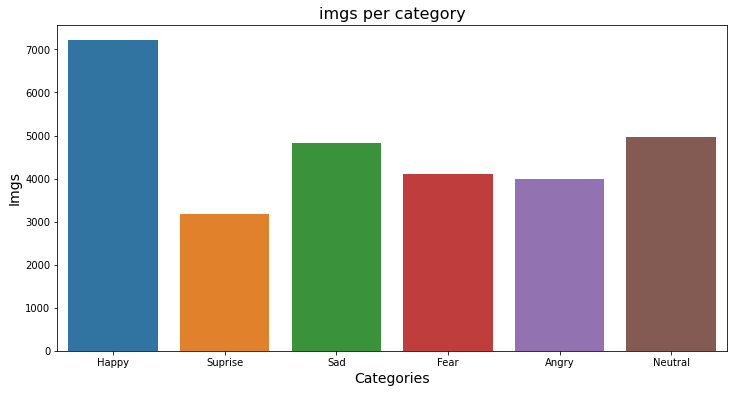

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=count)
plt.title('imgs per category', size=16)
plt.ylabel('Imgs', size=14)
plt.xlabel('Categories', size=14)
plt.show;

In [ ]:
import numpy as np
import torch
import torchvision
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


#GPU Utilities 


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Creating a Custom PyTorch Dataset

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 
train_tfms = tt.Compose([
                         tt.Resize(64),
                         tt.RandomCrop(50, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomRotate,
                         #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         #tt.ColorJitter(brightness=.1, contrast=.8, saturation=0.5, hue=0.12),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# Creating Training and Validation Sets

In [ ]:
train_ds = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, valid_tfms)

In [ ]:
def show_example(img, label):
    print(f'Label: {train_ds.classes[label]} ({label})')
    print(f'image.shape: {img.shape}')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry (0)
image.shape: torch.Size([3, 50, 50])
None


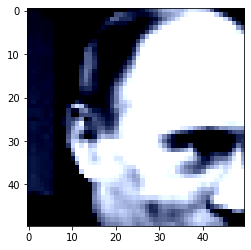

In [ ]:
print(show_example(*train_ds[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry (0)
image.shape: torch.Size([3, 50, 50])
None


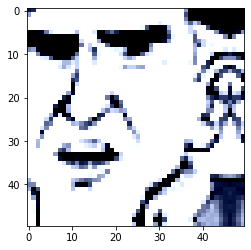

In [ ]:
print(show_example(*train_ds[101]))

In [ ]:
batch_size= 128

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=6, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=6, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


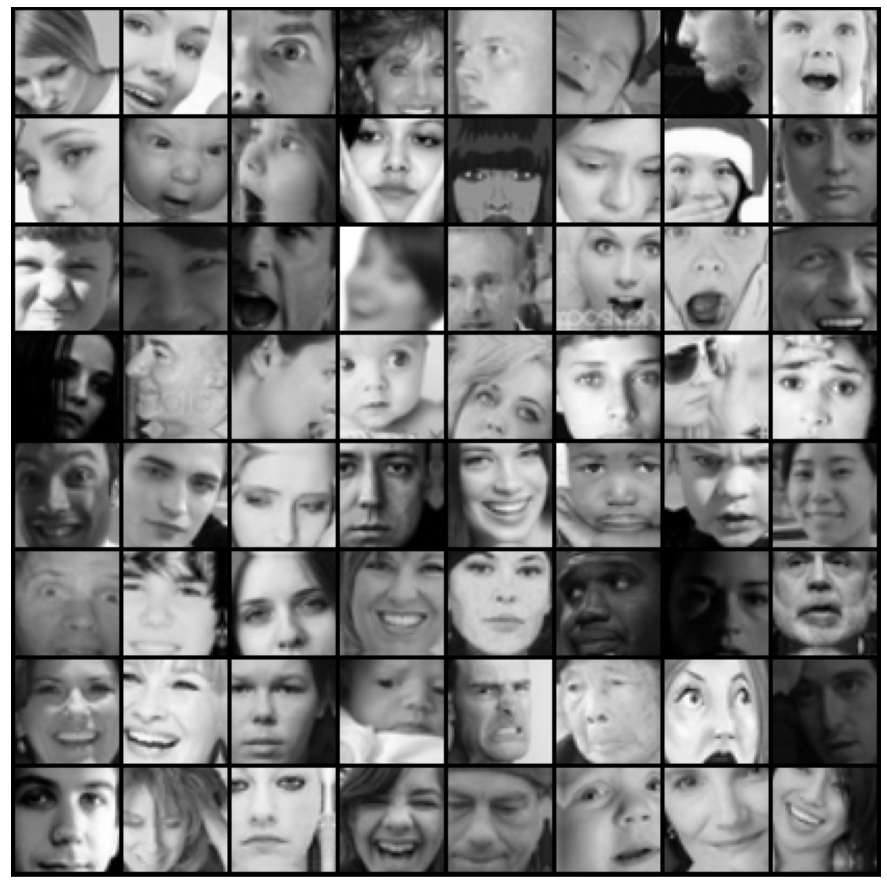

In [ ]:
show_batch(train_dl)

#Modifying a Pretrained Model (ResNet152)
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity.

An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers.

The depth of representations is of central importance for many visual recognition tasks. Solely due to our extremely deep representations, we obtain a 28% relative improvement on the COCO object detection dataset. Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions, where we also won the 1st places on the tasks of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation.

Authors: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun

<img src="https://www.researchgate.net/profile/Tin-Kramberger/publication/343615852/figure/fig1/AS:923861193330692@1597277081980/ResNet-152-neural-network-architecture-Slika-1-Arhitektura-ResNet-152-neuronske-mreze.ppm" style="max-width:420px; margin-bottom:32px"/>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class Resnet152Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

##Transfer Learning:
The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.
<img src="https://miro.medium.com/max/1276/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg" style="max-width:420px; margin-bottom:32px"/>

#Training Loop

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#Finetuning the Pretrained Model


In [ ]:
model = Resnet152Model(6,pretrained=True)
to_device(model, device)

Resnet152Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [ ]:
history = [evaluate(model, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.13794733583927155, 'val_loss': 2.0882365703582764}]

In [ ]:
%%time
history += fit_one_cycle(20,0.001,model,train_dl,test_dl,weight_decay=0.01,grad_clip=0.01,opt_func=torch.optim.Adam)

  0%|          | 0/221 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00010, train_loss: 1.4491, val_loss: 1.3561, val_acc: 0.4675


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00028, train_loss: 1.1969, val_loss: 1.2644, val_acc: 0.5156


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00052, train_loss: 1.1813, val_loss: 1.4945, val_acc: 0.4048


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00076, train_loss: 1.2427, val_loss: 1.4674, val_acc: 0.4240


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00094, train_loss: 1.3016, val_loss: 1.5466, val_acc: 0.3931


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00100, train_loss: 1.3213, val_loss: 1.5255, val_acc: 0.3964


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00099, train_loss: 1.3445, val_loss: 1.4691, val_acc: 0.4023


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00095, train_loss: 1.3291, val_loss: 1.6691, val_acc: 0.3334


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00089, train_loss: 1.3181, val_loss: 1.4891, val_acc: 0.4126


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00081, train_loss: 1.3058, val_loss: 1.4009, val_acc: 0.4457


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00072, train_loss: 1.2841, val_loss: 1.4316, val_acc: 0.4470


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00061, train_loss: 1.2557, val_loss: 1.3630, val_acc: 0.4667


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00050, train_loss: 1.2335, val_loss: 1.5012, val_acc: 0.4196


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00039, train_loss: 1.2005, val_loss: 1.3500, val_acc: 0.4734


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00028, train_loss: 1.1664, val_loss: 1.3643, val_acc: 0.4598


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00019, train_loss: 1.1332, val_loss: 1.2488, val_acc: 0.5209


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00011, train_loss: 1.1041, val_loss: 1.2431, val_acc: 0.5210


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00005, train_loss: 1.0728, val_loss: 1.2533, val_acc: 0.5199


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00001, train_loss: 1.0484, val_loss: 1.2237, val_acc: 0.5322


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00000, train_loss: 1.0354, val_loss: 1.2172, val_acc: 0.5341
CPU times: user 55min 55s, sys: 43min 21s, total: 1h 39min 16s
Wall time: 1h 40min 52s


#Results

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

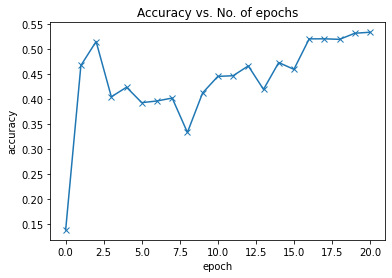

In [ ]:
plot_accuracies(history)

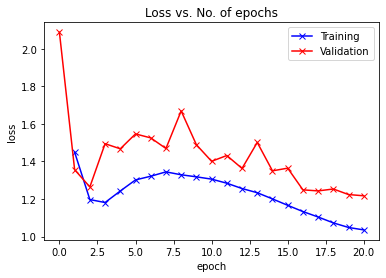

In [ ]:
plot_losses(history)

From the epoch vs loss graph we can see that firstly both the training data and testing data are decreasing simultaniously upto epoch 5.After that the training plotline started increasing for some time while the validation plotline is going parallely.

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity.png"/>

This phenomenon is called overfitting, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

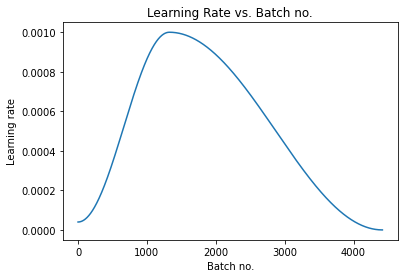

In [ ]:
plot_lrs(history)

#Testing the model against the test dataset to check the accuracy

In [ ]:
import random

In [ ]:
def denormalize(images, mean, std):
    invTrans = tt.Compose([ tt.Normalize(mean=[ 0., 0., 0. ],
                                                     std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                tt.Normalize(mean = [-1*mean[0], -1*mean[2], -1*mean[2] ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    return invTrans(images)

In [ ]:
def predict_img(img, label):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    print(f'Label: {train_ds.classes[label]}, Predicted: {train_ds.classes[pred]}')
    img = denormalize(img, *stats)
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Neutral


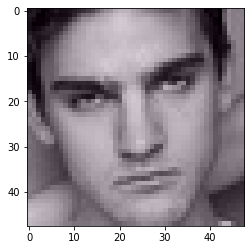

In [ ]:
predict_img(*test_ds[1])

Label: Sad, Predicted: Angry


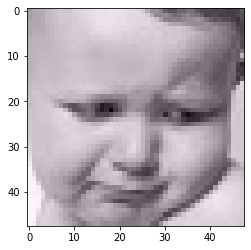

In [ ]:
predict_img(*test_ds[5000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


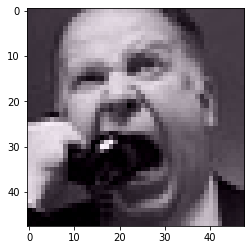

In [ ]:
predict_img(*test_ds[21])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


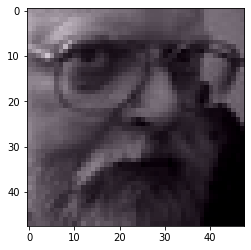

In [ ]:
predict_img(*test_ds[102])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Angry, Predicted: Angry


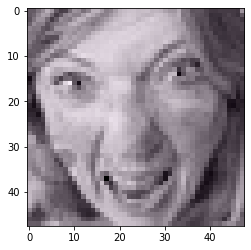

In [ ]:
predict_img(*test_ds[45])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Neutral, Predicted: Neutral


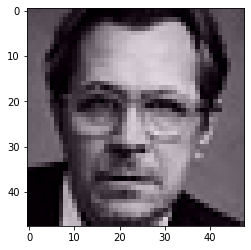

In [ ]:
predict_img(*test_ds[4000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Sad, Predicted: Sad


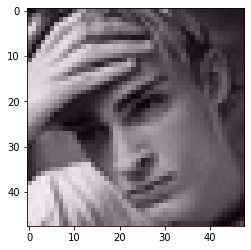

In [ ]:
predict_img(*test_ds[6000])

#Save the trained model

In [ ]:
torch.save(model.state_dict(), 'faces.pth')

#Conclusion:
Training for Facial expression recognition was much more difficult than I thought it would be, some expressions are fairly similar and it seems to create more error when trying to recognize certain expressions.

Maybe a bigger size picture Resize and Randomcrop can give a better result, but for that top quality, GPU is highly required otherwise it will give an "out of memory" error.

I also tried different learning rates and other approaches. Also tried DenseNet, but ResNet was better.